# SPICY Tutorial 3
This is the second tutorial exercise which deals with an Oseen vortex. 

We start by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.special as sc 
from spicy_class_2103 import spicy 

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

We define our domain boundaries and generate our synthetic data points. The data is sampled in $(x,y) = [-0.5,0.5]\times[-0.5,0.5]$.

The vortex is expressed as $u_r = 0$ and $u_\theta = \Gamma/2 \pi r \left( 1- e ^{-r^2/c_\theta}\right)$.

Here, $c_\theta = r_c^2 / \gamma$, with $r_c = 0.1$ the radial distance of maximum velocity, $\gamma = 1.25643$ and $\Gamma = 10$ the dimensionless circulation.

In [2]:
# Fix the random seed to ensure reproducibility
np.random.seed(42)

# Number of particles
n_p = 5000

# Define the domain boundaries and flow properties
x1_hat, x2_hat = -0.5, 0.5 # m, m
y1_hat, y2_hat = -0.5, 0.5 # m, m
rho = 1 # kg/m^3
mu = 0 # Pa s

# Generate the random points
X = np.random.random(n_p)*(x2_hat - x1_hat) + x1_hat
Y = np.random.random(n_p)*(y2_hat - y1_hat) + y1_hat

# Compute the radius and angle in the 2D domain
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)

# Hyperparameters of the vortex
Gamma = 10
r_c = 0.1
gamma = 1.256431
c_theta = r_c**2/gamma

# Compute the velocity field
u_theta = Gamma / (2*np.pi*r) * (1 - np.exp(-r**2 / (r_c**2 / gamma)))
U = np.sin(theta) * u_theta
V = -np.cos(theta) * u_theta 

# Add 10% noise to it
q = 0.1
U_noise = U * (1 + q*np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q*np.random.uniform(-1, 1, size = V.shape))


## Velocity regression

We start with the regression of the velocity field.

#### Step 1: Initialize the SPICY class

In [3]:
SP_vel = spicy([U_noise,V_noise], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

In [4]:
SP_vel.clustering([6,50], r_mM=[0.05,0.7], eps_l=0.88)

Clustering level 0 completed
Clustering level 1 completed


#### Step 3: Define the boundary conditions
We use 196 divergence-free boundary conditions, equally sampled at the edges of our domain

In [5]:
# Number of points for the vertical and horizontal boundary
n_c_V = n_c_H = 50

# Left boundary
X_Div1 = np.ones(n_c_V)*(x1_hat)
Y_Div1 = np.linspace(y1_hat, y2_hat, n_c_V)
# Bottom boundary
X_Div2 = np.linspace(x1_hat, x2_hat, n_c_H)
Y_Div2 = np.ones(n_c_H)*y1_hat
# Right boundary
X_Div3 = np.ones(n_c_V)*x2_hat
Y_Div3 = np.linspace(y1_hat, y2_hat, n_c_V)
# Top boundary
X_Div4 = np.linspace(x1_hat, x2_hat, n_c_H)
Y_Div4 = np.ones(n_c_H)*y2_hat

# Assemble to obtain the entire array of boundary conditions
X_Div=np.hstack((X_Div1,X_Div2,X_Div3,X_Div4))
Y_Div=np.hstack((Y_Div1,Y_Div2,Y_Div3,Y_Div4))

# we remove the duplicates
_, valid_idcs = np.unique(np.column_stack((X_Div, Y_Div)), return_index = True, axis = 0)
X_Div = X_Div[valid_idcs]
Y_Div = Y_Div[valid_idcs]
DIV = [X_Div, Y_Div]

# We set the constraints in these points and also place additional RBFs in each of these points|
SP_vel.vector_constraints(DIV=DIV, extra_RBF=True)

0 D conditions assigned
0 N conditions assigned
196 Div conditions assigned


We can look at the clustering result, the left-hand side shows the RBFs in 2D, the right hand side shows the diameter distribution.

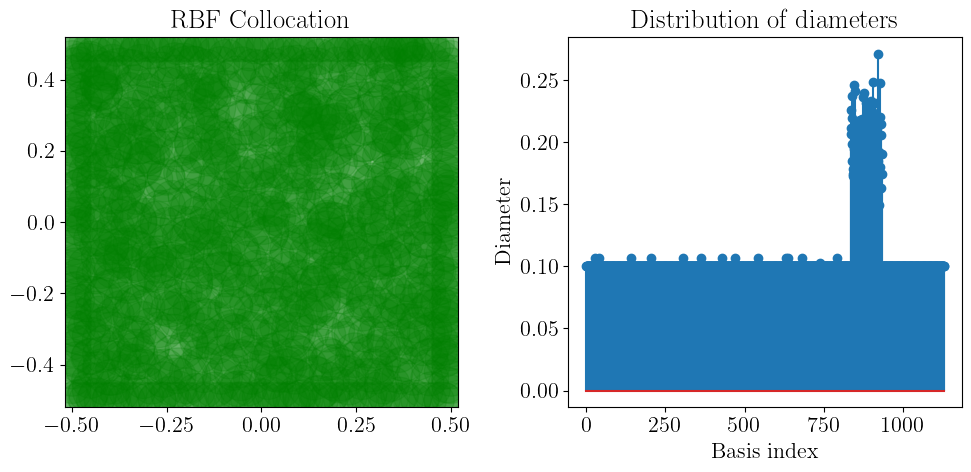

In [6]:
SP_vel.plot_RBFs()

#### Step 4: Assemble the linear system
We assemble the regression, with a penalty for a divergence-free flow

In [7]:
SP_vel.Assembly_Regression(alpha_div=1)

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [8]:
SP_vel.Solve(K_cond=1e8)

Solving with constriaints
Matrix A regularized
Chol factor of M WITHOUT regularization
Lambdas computed
w computed


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [9]:
solution_velocity = SP_vel.Get_Sol(grid=[X,Y])
# Extract individual velocity components
U_calc = solution_velocity[:n_p]
V_calc = solution_velocity[n_p:]

We can now compute the error in the magnitude, which is below 1%.

In [10]:
# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)
# Error in u
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
# Error in v
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)

print('Total velocity error: {0:.3f}%'.format(error_magn*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v*100))

Total velocity error: 0.637%
Velocity error in u:  0.808%
Velocity error in v:  0.771%


We can now show the resulting velocity field as well as the error. 

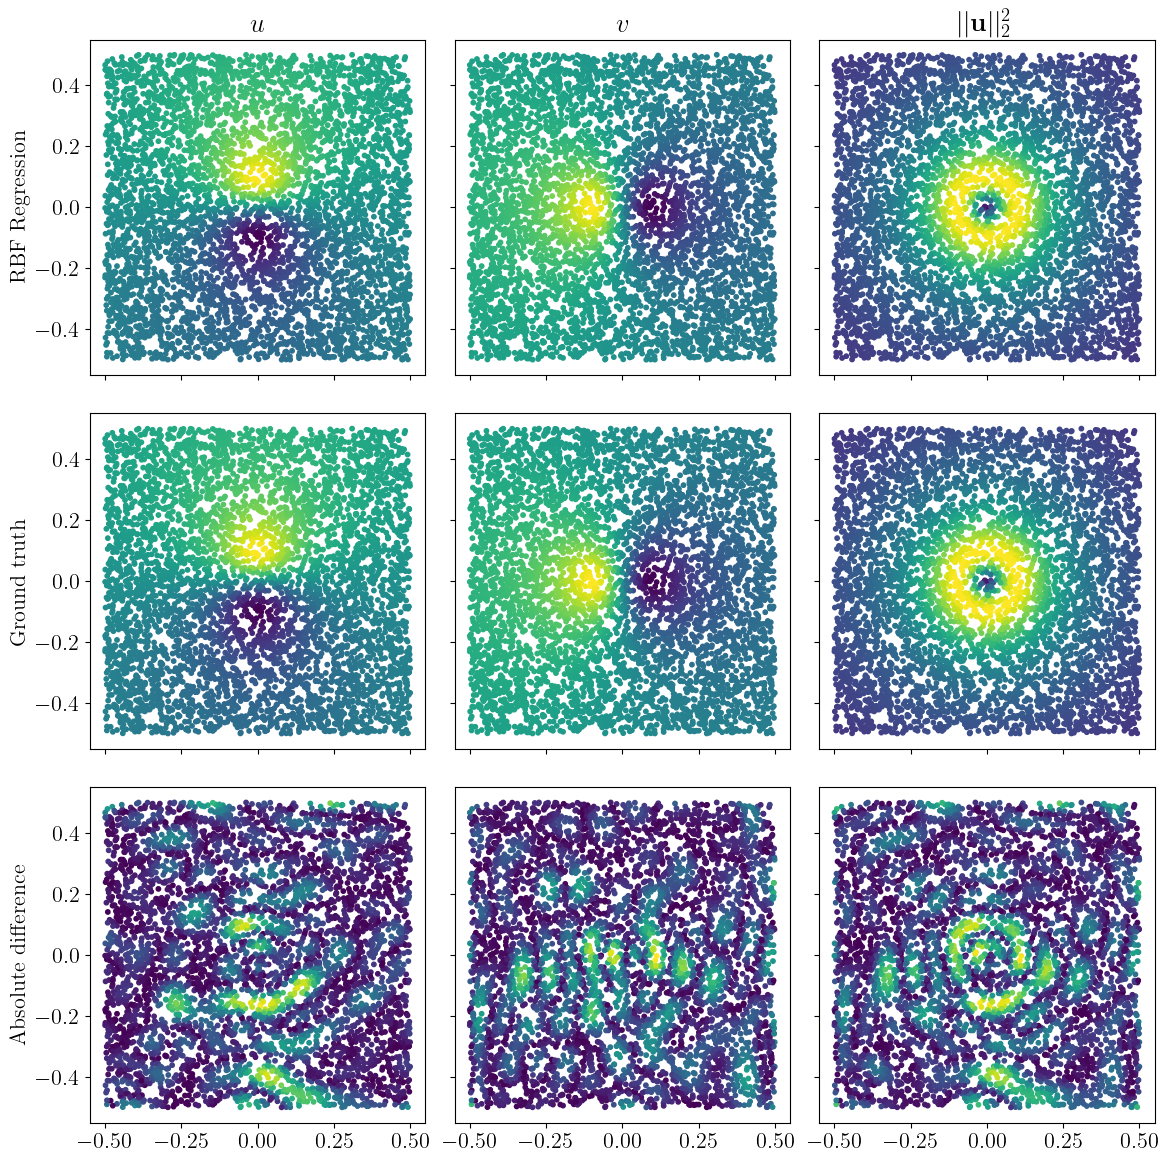

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,12), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X, Y, c=U_calc, s=10)
axes[1,0].scatter(X, Y, c=U, s=10)
axes[2,0].scatter(X, Y, c=np.abs(U_calc-U), s=10) 

axes[0,1].scatter(X, Y, c=V_calc, s=10)
axes[1,1].scatter(X, Y, c=V, s=10)
axes[2,1].scatter(X, Y, c=np.abs(V_calc-V), s=10)  

axes[0,2].scatter(X, Y, c=U_magn_calc, s=10)
axes[1,2].scatter(X, Y, c=U_magn, s=10)
axes[2,2].scatter(X, Y, c=np.abs(U_magn_calc-U_magn), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference') 

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$||\mathbf{u}||_2^2$')           
for ax in axes.flatten():
    ax.set_aspect(1)      
fig.tight_layout()       

From left to right, the figure shows the computed velocity field, the analytical velocity field and the difference in their magnitude. The error is uniformly distributed and strongest around the center where the largest gradients are present which is expected. With the analytic expression of the velocity field, we can now continue with the pressure integration



## Pressure integration

For the pressure, we must compute two quantities from the velocity field. The first is the r.h.s. of equation (21) which is available analytically. The second are the values of the Neumann conditions on the boundaries, from equation (29).

We evaluate the source term on the original grid points, but this can also be an arbitrary grid.

In [12]:
# Get the source term
source_term = SP_vel.Evaluate_Source_Term(grid = [X, Y], rho = rho)

For the boundary conditions, we must again define the points in which we want to compute them. They could be the same as for the divergence free points, but they can also be redefined. Also, the poisson equation requires one Dirichlet boundary condition. We set this one in the bottom left corner at $(x,y) = (-0.5, -0.5)$

In [13]:
# Get the one dirichlet condition from the analytical solution
X_pres = -0.5; Y_pres = -0.5
radius_pres = np.sqrt(X_pres**2+Y_pres**2)
u_theta_pres = Gamma/(2*np.pi*radius_pres)*(1-np.exp(-radius_pres**2/c_theta))
pres_dir = -np.array([0.5*rho*(u_theta_pres)**2-\
                rho*Gamma**2/(4*np.pi**2*c_theta)*(sc.exp1(radius_pres**2/c_theta)-sc.exp1(2*radius_pres**2/c_theta))])

# Number of points for the vertical and horizontal boundary
n_c_V = n_c_H = 50
# Left boundary
X_Pres_N1=np.ones(n_c_V)[1:]*(x1_hat) # we remove the point where our Dirichlet condition is
Y_Pres_N1=np.linspace(y1_hat,y2_hat,n_c_V)[1:] # we remove the point where our Dirichlet condition is
# Bottom boundary
X_Pres_N2=np.linspace(x1_hat,x2_hat,n_c_H)[1:] # we remove the point where our Dirichlet condition is
Y_Pres_N2=np.ones(n_c_H)[1:]*y1_hat # we remove the point where our Dirichlet condition is
# Right boundary
X_Pres_N3=np.ones(n_c_V)*x2_hat
Y_Pres_N3=np.linspace(y1_hat,y2_hat,n_c_V)
# Top boundary
X_Pres_N4=np.linspace(x1_hat,x2_hat,n_c_H)
Y_Pres_N4=np.ones(n_c_H)*y2_hat
# Assemble the individual arrays
X_Pres_N=np.hstack((X_Pres_N1,X_Pres_N2,X_Pres_N3,X_Pres_N4))
Y_Pres_N=np.hstack((Y_Pres_N1,Y_Pres_N2,Y_Pres_N3,Y_Pres_N4))

# we assemble the normals in the same way
# Left boundary
n_x_1 = np.ones(n_c_V)[1:]*(-1)
n_y_1 = np.ones(n_c_V)[1:]*0
# Bottom boundary
n_x_2 = np.ones(n_c_H)[1:]*0
n_y_2 = np.ones(n_c_H)[1:]*(-1)
# Right boundary
n_x_3 = np.ones(n_c_V)*1
n_y_3 = np.ones(n_c_V)*0
# Top boundary
n_x_4 = np.ones(n_c_H)*0
n_y_4 = np.ones(n_c_H)*(1)
# Assemble to obtain the entire array of normals
n_x = np.hstack((n_x_1, n_x_2, n_x_3, n_x_4))
n_y = np.hstack((n_y_1, n_y_2, n_y_3, n_y_4)) 

# Remove the duplicates again
_, valid_idcs = np.unique(np.column_stack((X_Pres_N, Y_Pres_N)),
                          return_index = True, axis = 0)
X_Pres_N = X_Pres_N[valid_idcs]
Y_Pres_N = Y_Pres_N[valid_idcs]
n_x = n_x[valid_idcs]
n_y = n_y[valid_idcs]

# Evaluate the Neumann conditions in these points
P_Neu = SP_vel.Get_Pressure_Neumann(grid = [X_Pres_N, Y_Pres_N], normals = [n_x, n_y],
                                    rho = rho, mu = mu)

Now, we have all of the quantities, that we need from the velocity. The velocity spicy class can now be deleted, to save memory but for the sake of this tutorial, all variables are kept.

#### Step 1: Initialize the SPICY class

In [14]:
SP_pres = spicy([source_term], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

In [15]:
SP_pres.clustering([6,50], r_mM=[0.05, 0.7], eps_l=0.88)

Clustering level 0 completed
Clustering level 1 completed


#### Step 3: Define the boundary conditions
We use 195 Neumann and one Dirichlet boundary condition.

In [16]:
# We assemble our Neumann and Dirichlet B.C.
NEU_P = [X_Pres_N, Y_Pres_N, n_x, n_y, P_Neu]
DIR_P = [np.array([X_pres]), np.array([Y_pres]), pres_dir]

# And, we set them
SP_pres.scalar_constraints(DIR=DIR_P, NEU=NEU_P, extra_RBF=True)

1 Dirichlet conditions assigned
195 Neumann conditions assigned


#### Step 4: Assemble the linear system
We assemble the regression, with no harmonic basis.

In [17]:
SP_pres.Assembly_Poisson()

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^8$.

In [18]:
SP_pres.Solve(K_cond=1e8)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6 Obtain the solution

In [19]:
P_calc = SP_pres.Get_Sol(grid=[X, Y])

We can now compute the error in the magnitude

In [20]:
# Compute the analytical pressure field
u_theta = Gamma/(2*np.pi*r)*(1-np.exp(-r**2/c_theta))
P_corr = -0.5*rho*u_theta**2-rho*Gamma**2/(4*np.pi**2*c_theta)*(sc.exp1(r**2/c_theta)-sc.exp1(2*r**2/c_theta))

# print the pressure error
error_p = np.linalg.norm(P_calc-P_corr)/np.linalg.norm(P_corr)
print('Total pressure error: {0:.3f}%'.format(error_p*100))


Total pressure error: 0.549%


We can now show the resulting velocity field as well as the error.

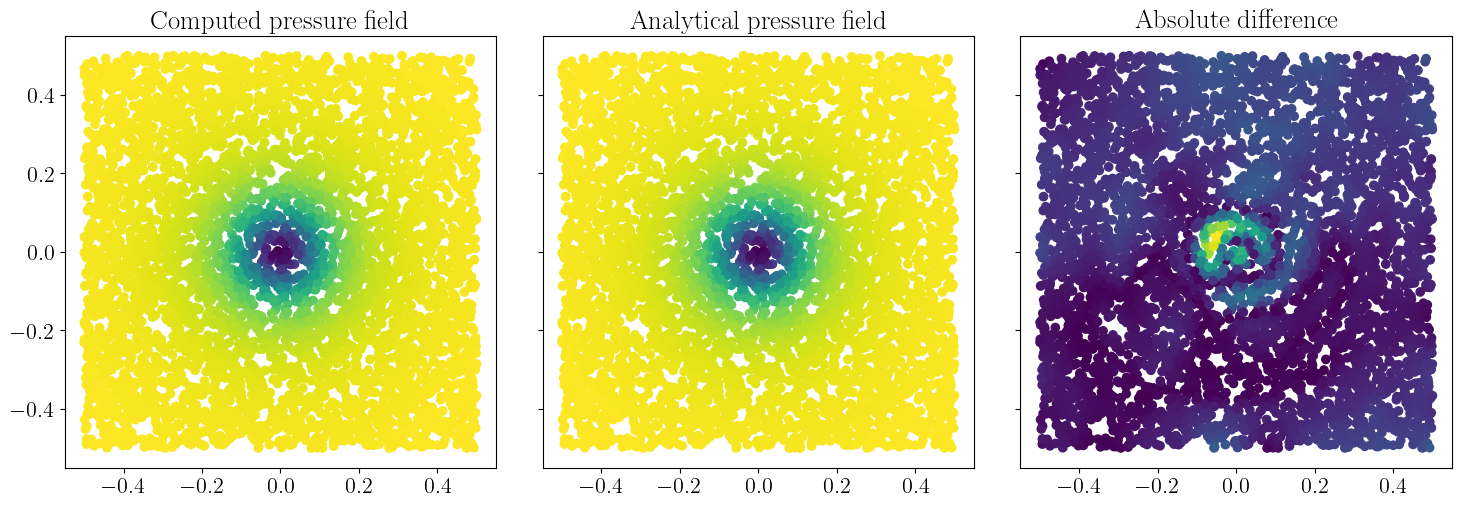

In [21]:
fig, axes = plt.subplots(figsize=(15,5), dpi=100, ncols=3, sharex=True, sharey=True)
axes[0].scatter(X, Y, c=P_calc)
axes[0].set_title('Computed pressure field')
axes[1].scatter(X, Y, c=P_corr)
axes[1].set_title('Analytical pressure field')
axes[2].scatter(X, Y, c=np.abs(P_calc - P_corr))
axes[2].set_title('Absolute difference')             
for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()

As expected, the difference in the pressure field is the strongest in the center, where the largest gradient is located. However, the error is almost neglibile given the fact that there is 10% noise on the velocity data.